<a href="https://colab.research.google.com/github/ttogle918/AI_projects/blob/master/sprint2_project/sprint2_cinema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ㅁㅁ시네마** 재상영 영화 선택 중 데이터 손상 발견!!
종영된 영화 중 관객 만족도가 높았던 영화들을 꼽아 우리 ㅁㅁ시네마에서 재상영을 하려 합니다. 

그런데 영화 데이터 일부가 손상되었다는 것을 알아차렸습니다.

우리는 고객 만족도, 즉 rating이 3.5 점 이상인 영화 중 재상영할 영화를 선택할 것이기 때문에, **rating 데이터**를 우선 복원하려 합니다.

## Movie rating이 3.5점이상인가? 예측

## 파일 가져오기 및 패키지 정의

In [1]:
# google 드라이브에 로컬 파일 업로드
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter

In [3]:
import ast
def getDataFrame(s) :
  if s[0] == '\'' :
    s = s[1:-1]
  if str(s)[0] == '{' :
    df = pd.DataFrame([ast.literal_eval(s)])
  if str(s)[0] == '[' :
    df = pd.DataFrame(ast.literal_eval(s))
  else :
    df = s
    print(s)
  return df

In [4]:
credits = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/credits.csv")
keywords = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/keywords.csv")
links = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links.csv")
links = links.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/links_small.csv"))
movies_metadata = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/movies_metadata.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings.csv")
ratings = ratings.append(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/code_states/ratings_small.csv"))

credits.shape, keywords.shape, links.shape, movies_metadata.shape, ratings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((45476, 3), (46419, 2), (54968, 3), (45466, 24), (26124293, 4))

## 전체 데이터

|  <center>credit</center> |  <center>cast</center> |
|:--------:|:--------|
|**credit** |cast(id, keywords), crew(credit_id, de), id> |
|**keywords** | id (id, name), keywords(id) |
|**links** | movieId, imdbId, tmdbId |
|**movies_metadata** | adult, belongs_to_collection, budget, genres |
|**''** | homepage, id, imdb_id, original_language |
|**''** | original_title, overview, popularity, poster_path |
|**''** | production_companies, production_countries |
|**''** | release_date, revenue, runtime, spoken_languages |
|**''** | status, tagline, title, video, vote_average, vote_count |
|**ratings** | userId, movieId, rating, timestamp |

## 데이터 다듬기
1. Credit
2. Keywords
3. Links
4. Movies_metadata
5. Ratings

### credits : 극 중 등장인물에 대한 정보와 제작진에 대한 정보를 담고있는 dataframe
이 credits의 데이터 중 우리는 배우의 이름과 책임 감독의 이름만 궁금할 것이다.

그러므로 cast에서는 상위 4명(주연), crew에서는 상위 4명(감독 혹은 작가)을 뽑아내었다.

#### 과연 주연과 감독/PD가 영화 평점에 영향을 미칠까?

In [5]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [6]:
# 1. 중복된 값 지우기
credits.duplicated().sum()

37

In [7]:
credits = credits.drop_duplicates()

In [8]:
print('empty cast', len(credits[credits.cast == '[]']) )
print('empty crew', len(credits[credits.crew == '[]']) )

empty cast 2414
empty crew 771


In [9]:
# 2. null값, empty값 확인 -> 지우기
credits = credits[(credits.cast != '[]') & (credits.crew != '[]')]
credits.shape

(42675, 3)

In [10]:
print(len(credits['id'].unique())) # id당 한 row가 아니다!

42668


In [11]:
# cast의 내용은 같고 credit_id의 값만 다르기 때문에 삭제해도 된다 -> id는 unique()
credits = credits.drop(credits[credits['id'].duplicated() == True].index)
print(credits.shape)
credits.head(3)

(42668, 3)


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


### cast
cast에서 배우 이름을 따로 저장
영화의 주/조연(상위 8명이라고 가정)으로 자주 출연한 사람을 인기 많은 배우라고 가정하고, 인기 많은 배우 40인을 선택한다.


해당 영화에 인기 많은 배우(most_popular_actors)가 몇 명 있는지 세어 새로운 데이터(number_of_named_actors)를 생성한다.



In [12]:
# 4. cast에서 배우 이름 따로 저장, crew에서 감독 이름 따로 저장
# string 형태로 data 형태 바꾸기
li = [entry['name'] for entry in  ast.literal_eval(credits.cast[0])[0:4]]
li

['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney']

In [13]:
# cast 상위 8명만
import re

def set_list_to_string(s, idx, to) :
  if to == 0 :
    t_dict = ast.literal_eval(s)
    return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]
  
  t_dict = ast.literal_eval(s)[0:to]
  return [re.sub(r'[^\w]', '_',re.sub(r'[^\w\s]', '', entry[idx])) for entry in t_dict]

In [14]:
credits['actors'] = credits.cast.apply(set_list_to_string, idx='name', to=8)
credits['actors'].head(10)

0    [Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...
1    [Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...
2    [Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...
3    [Whitney_Houston, Angela_Bassett, Loretta_Devi...
4    [Steve_Martin, Diane_Keaton, Martin_Short, Kim...
5    [Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Vo...
6    [Harrison_Ford, Julia_Ormond, Greg_Kinnear, An...
7    [Jonathan_Taylor_Thomas, Brad_Renfro, Rachael_...
8    [JeanClaude_Van_Damme, Powers_Boothe, Dorian_H...
9    [Pierce_Brosnan, Sean_Bean, Izabella_Scorupco,...
Name: actors, dtype: object

In [15]:
# 가장 많이 나온 배우 40명을 most_popular_acctors이라고 가정
from collections import Counter

actor_count = Counter([name for names_per_film in credits.actors.values for name in names_per_film])
most_popular_actors = [entry[0] for entry in actor_count.most_common(40)]
credits['number_of_named_actors'] = credits['actors'].apply(len)
credits.head(3)

,cast,crew,id,actors,number_of_named_actors
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney...",8
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[Robin_Williams, Jonathan_Hyde, Kirsten_Dunst,...",8
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[Walter_Matthau, Jack_Lemmon, AnnMargret, Soph...",7


In [16]:
def listToString(item_list):
  return r' '.join(item_list)

credits['actors'] = credits['actors'].apply(listToString)

### Crew

영화의 스태프(Crew)(상위 4명이라고 가정)으로 자주 출연한 사람을 인기 많은 크루라고 가정하고, 인기 많은 크루 40인을 선택한다.

해당 영화의 크루 목록에 인기 많은 크루(most_popular_crews)가 몇 명 있는지 세어 새로운 데이터(number_of_named_crews)를 생성한다.


In [17]:
credits['crew'] = credits.crew.apply(set_list_to_string, idx='name', to=4)
credits.crew[0]

['John_Lasseter', 'Joss_Whedon', 'Andrew_Stanton', 'Joel_Cohen']

In [18]:
# 가장 많이 나온 crew 40명을 most_popular_crew라고 가정
from collections import Counter

crew_count = Counter([name for names_per_film in credits.crew.values for name in names_per_film])
most_popular_crews = [entry[0] for entry in crew_count.most_common(40)]
credits['number_of_named_crews'] = credits['crew'].apply(len)

credits['crew'] = credits['crew'].apply(listToString)
credits.head(3)

,cast,crew,id,actors,number_of_named_actors,number_of_named_crews
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...",John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4


In [19]:
credits = credits.drop(['cast'], axis=1)

### 배우들이 영화에 주연으로 출연한 수에 따른 그래프와 영화에 참여한 크루의 수 

In [20]:
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(actor_count.most_common(40)[i][0])
  y_value.append(actor_count.most_common(40)[i][1])

df_actor_count = pd.DataFrame(data={'actor':x_value, 'count':y_value})
df_actor_count.head(10)

,actor,count
0,Christopher_Lee,115
1,John_Wayne,112
2,Jackie_Chan,103
3,Gérard_Depardieu,103
4,Michael_Caine,102
5,Robert_De_Niro,100
6,Samuel_L_Jackson,97
7,Donald_Sutherland,92
8,Danny_Glover,86
9,Harvey_Keitel,85


In [21]:
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(crew_count.most_common(40)[i][0])
  y_value.append(crew_count.most_common(40)[i][1])

df_crew_count = pd.DataFrame(data={'crew':x_value, 'count':y_value})
df_crew_count.head(10)

,crew,count
0,Cedric_Gibbons,189
1,Avy_Kaufman,132
2,Roger_Corman,127
3,Max_Steiner,122
4,Ennio_Morricone,116
5,Darryl_F_Zanuck,116
6,Charlie_Chaplin,115
7,Luc_Besson,108
8,Werner_Herzog,104
9,Hal_B_Wallis,102


In [22]:
credits.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4


## 막대 그래프로 생성한 데이터를 살펴봅시다.

#### 가장 인기있는 배우 40인과, 비중있는 역할로 출연한 영화의 수는?

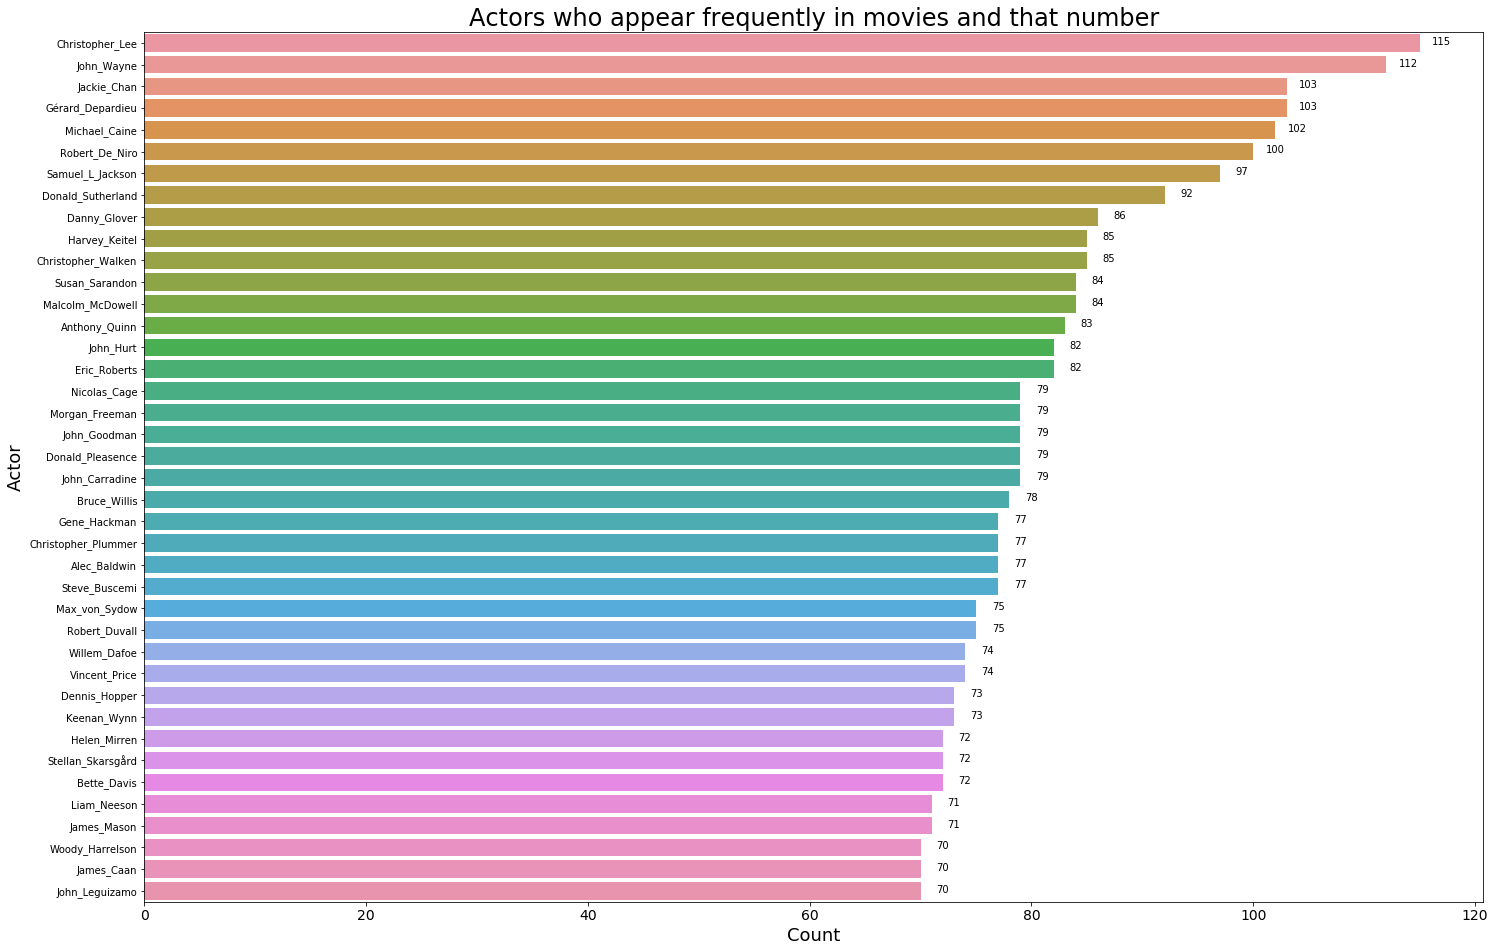

In [23]:
# Count of Actors in the Movie
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))

g = sns.barplot(data= df_actor_count, x= "count",y= "actor", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Actors who appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Actor', fontsize=18)

plt.show()

#### 가장 인기있는 크루 40인과, 주요 스태프로 함께한 영화의 수는?

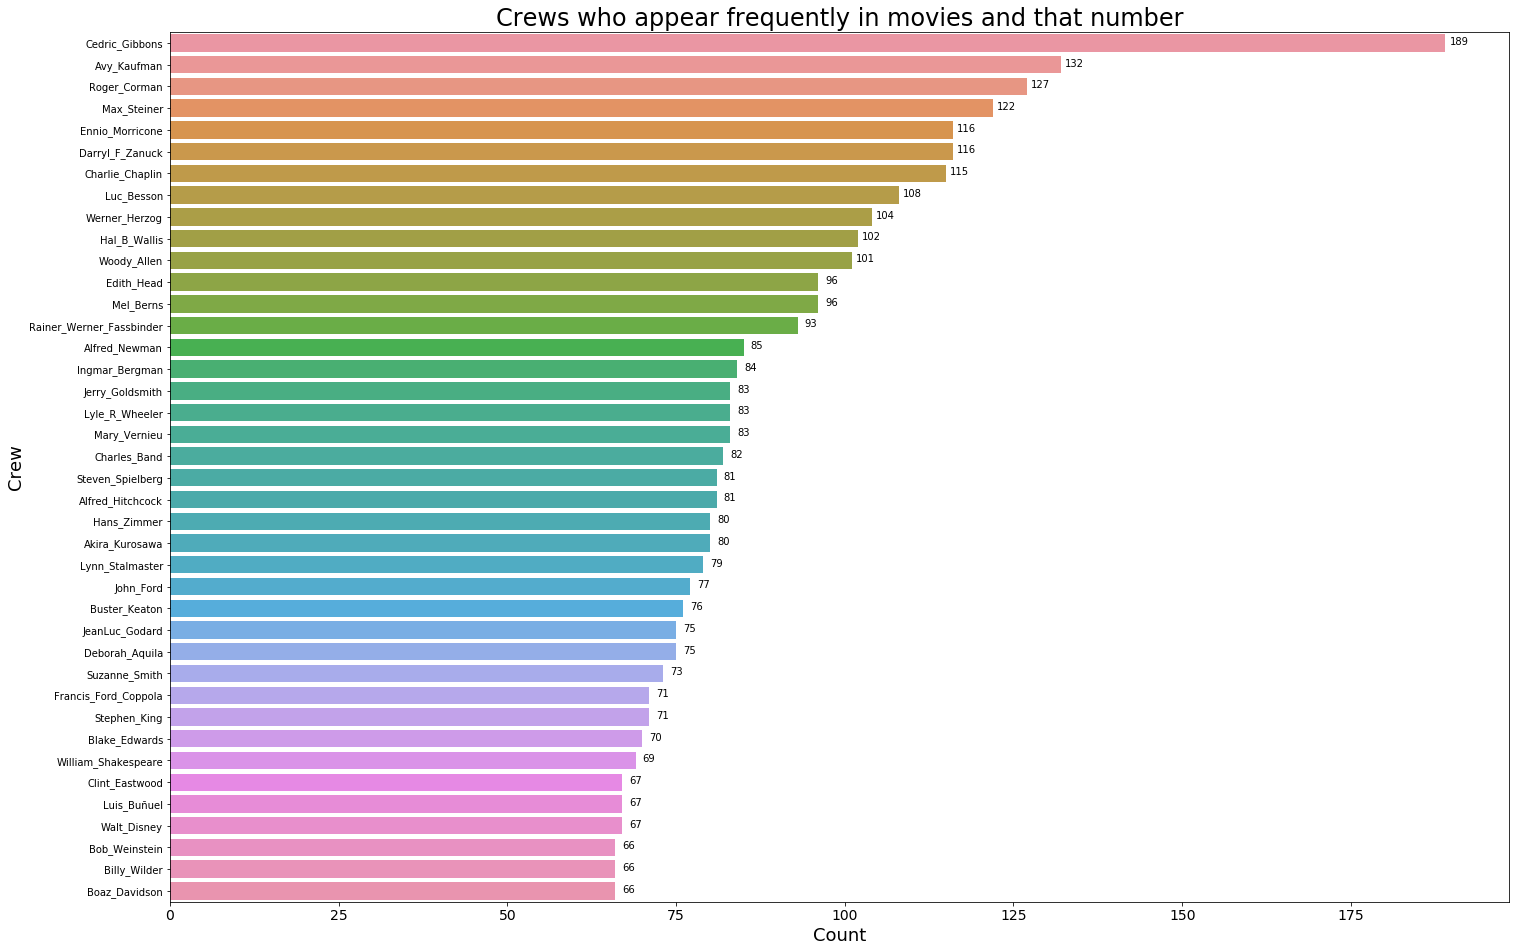

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))

g = sns.barplot(data= df_crew_count, x= "count",y= "crew", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Crews who appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Crew', fontsize=18)

plt.show()





---



## keywords : 극 중 키워드 단어를 담고있는 dataframe
 과연 키워드가 영화 평점에 영향을 미칠까?

### keywords

영화의 키워드(keywords)로 많이 등록된 단어를 인기 많은 키워드라고 가정하고, 인기 많은 키워드 40개를 선택한다.

해당 영화의 키워드 목록에 인기 많은 키워드(most_popular_keywords)가 몇 개 있는지 세어 새로운 데이터(number_of_named_keyword)를 생성한다.

In [25]:
# 0번째 list로 test
[entry['name'] for entry in  ast.literal_eval(keywords.keywords[0])]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [26]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
keywords['keywords'] = keywords.keywords.apply(set_list_to_string, idx='name', to=0)
keywords.head(3)

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board_game, disappearance, based_on_childrens..."
2,15602,"[fishing, best_friend, duringcreditsstinger, o..."


In [27]:
# 가장 많이 나온 키워드 40개를 most_popular_keywords라고 가정
from collections import Counter

keyword_count = Counter([name for names_per_film in keywords.keywords.values for name in names_per_film])
most_popular_keywords = [entry[0] for entry in keyword_count.most_common(40)]
keywords['number_of_named_keyword'] = keywords['keywords'].apply(len)

# 아래 시각화를 위해서 정의
x_value = list()
y_value = list()
for i in range(40) :
  x_value.append(keyword_count.most_common(40)[i][0])
  y_value.append(keyword_count.most_common(40)[i][1])

df_keyword_count = pd.DataFrame(data={'keyword':x_value, 'count':y_value})
df_keyword_count.head(10)

,keyword,count
0,woman_director,3115
1,independent_film,1930
2,murder,1308
3,based_on_novel,835
4,musical,734
5,sex,685
6,violence,651
7,nudity,636
8,biography,629
9,revenge,626


In [28]:
keywords['keywords'] = keywords['keywords'].apply(listToString)
keywords.head(3)

,id,keywords,number_of_named_keyword
0,862,jealousy toy boy friendship friends rivalry bo...,9
1,8844,board_game disappearance based_on_childrens_bo...,6
2,15602,fishing best_friend duringcreditsstinger old_men,4


In [29]:
keywords['keywords'].unique()

array(['jealousy toy boy friendship friends rivalry boy_next_door new_toy toy_comes_to_life',
       'board_game disappearance based_on_childrens_book new_home recluse giant_insect',
       'fishing best_friend duringcreditsstinger old_men', ...,
       'blair_witch', 'witch mythology legend serial_killer mockumentary',
       'artist play pinoy'], dtype=object)

### keyword의 수 그래프

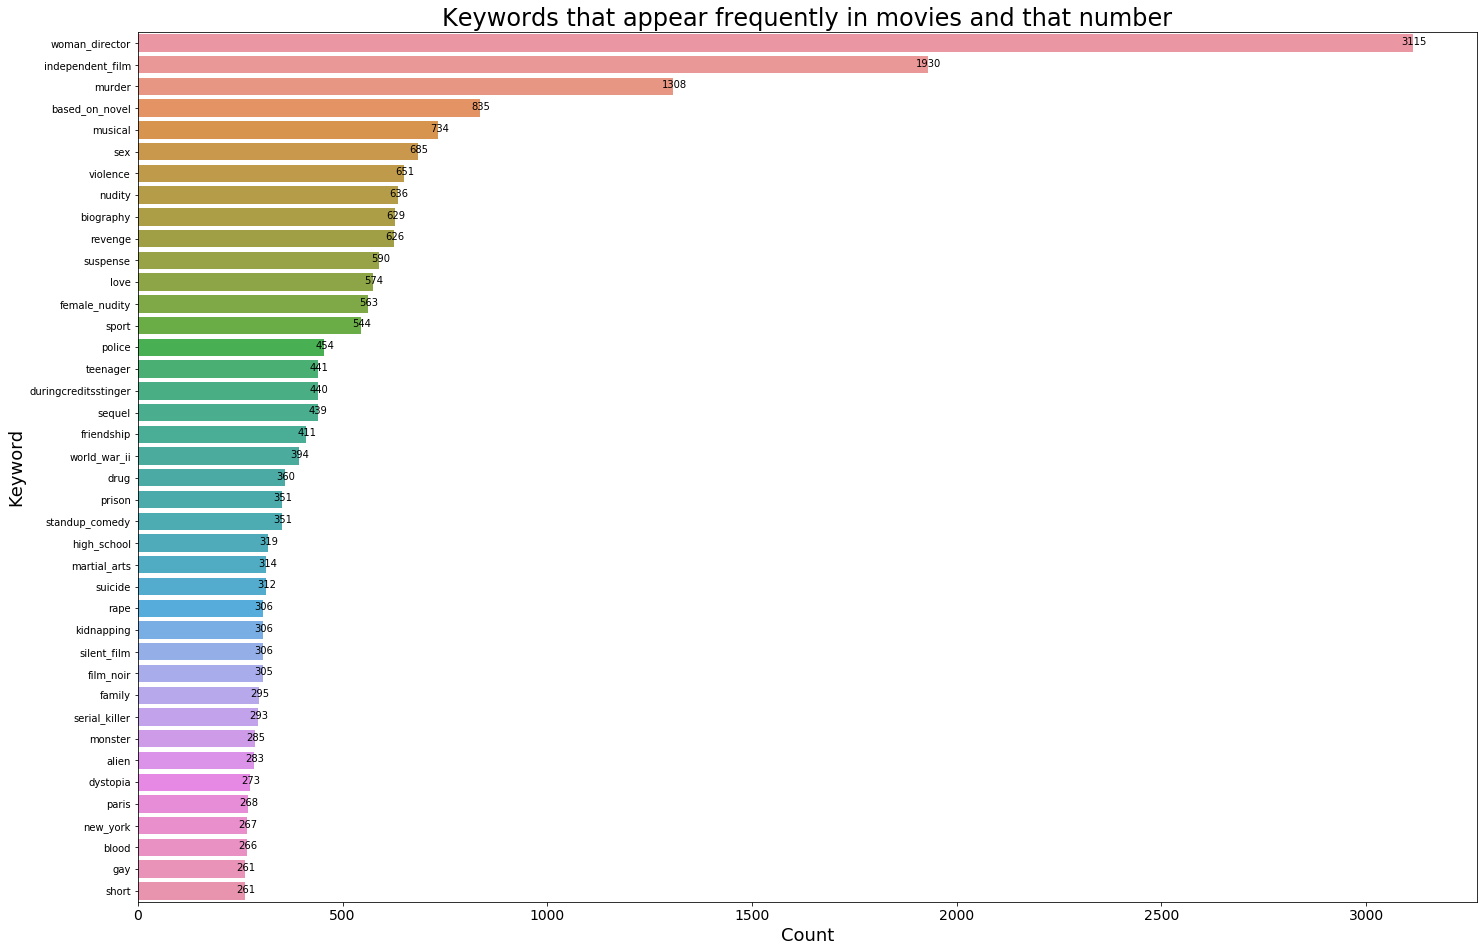

In [30]:
# Keywords that appear frequently in movies and that number
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(24, 16))
g = sns.barplot(data= df_keyword_count, x= "count",y= "keyword", ci=None)
ax = g

#annotate axis = seaborn axis 
for p in ax.patches: 
    ax.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width()+2, p.get_y()+p.get_height()), 
       ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

plt.xticks(fontsize=14, rotation=0)
plt.title("Keywords that appear frequently in movies and that number", fontsize=24)
plt.xlabel('Count', fontsize=18)
plt.ylabel('Keyword', fontsize=18)
plt.show()

## credit과 keywords merge

In [31]:
merged_df = pd.merge(credits, keywords, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4,jealousy toy boy friendship friends rivalry bo...,9
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4,board_game disappearance based_on_childrens_bo...,6
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4,fishing best_friend duringcreditsstinger old_men,4




---



## links : dataframe끼리 연결해주는 id를 가지는 데이터프레임

In [32]:
links.columns = ['movieId', 'imdbId', 'id']
links.head(1)

,movieId,imdbId,id
0,1,114709,862.0


In [33]:
links = links.drop_duplicates()

In [34]:
links.isnull().sum()

movieId      0
imdbId       0
id         222
dtype: int64

### merge : 훈련하기 위해 위의 데이터들을 모두 통합한 데이터 프레임 생성


In [35]:
merged_df = pd.merge(merged_df, links, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId
0,John_Lasseter Joss_Whedon Andrew_Stanton Joel_...,862,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,8,4,jealousy toy boy friendship friends rivalry bo...,9,1,114709
1,Larry_J_Franco Jonathan_Hensleigh James_Horner...,8844,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,8,4,board_game disappearance based_on_childrens_bo...,6,2,113497
2,Howard_Deutch Mark_Steven_Johnson Mark_Steven_...,15602,Walter_Matthau Jack_Lemmon AnnMargret Sophia_L...,7,4,fishing best_friend duringcreditsstinger old_men,4,3,113228




---



## movies_metadata : 영화에 대한 정보를 담고있는 dataframe

과연 예산과 장르, 상영시간, 판매회사가 영화 평점에 영향을 미칠까?

+ movies_metadata에서 필요없는 컬럼 삭제 ( ['original_language', 'original_title', 'overview', 'poster_path', 'tagline'] )
+ homepage컬럼은 유/무로 판단(있다면 1, 없다면 0)
+ poster_path는 유/무로 판단하려 했으나 대부분 있음이므로 유의미하지 않다. -> **삭제**

+ spoken_languages는 언어가 몇가지인지로 적는다. ( 이 영화에 대한 기대감과 투자의 정도를 알 수 있을 것이다. )

In [36]:
movies_metadata.duplicated().sum()

13

In [37]:
movies_metadata = movies_metadata.drop_duplicates()

In [38]:
print(movies_metadata.shape)
movies_metadata.head(2)

(45453, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [39]:
print(movies_metadata.revenue.mean())
print(movies_metadata.revenue.median())
movies_metadata.status.unique()

11212544.046889784
0.0


array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [40]:
movies_metadata.isnull().sum()

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [41]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [42]:
def toint(s) :
  try :
    n = int(s)
    return n
  except :
    print(s)
    return s
movies_metadata.budget.apply(toint)

/ff9qCepilowshEtG2GYWwzt2bs4.jpg
/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg
/zaSf5OG7V8X8gqFvly88zDdRm46.jpg


0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45453, dtype: object

In [43]:
# 본인의 columns 위치가 아닌 곳에 데이터가 있는 data들 drop
movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/ff9qCepilowshEtG2GYWwzt2bs4.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg'].index)
movies_metadata = movies_metadata.drop(index=movies_metadata[movies_metadata.budget == '/zaSf5OG7V8X8gqFvly88zDdRm46.jpg'].index)
print(movies_metadata.shape)
movies_metadata.id = movies_metadata.id.astype(int)

(45450, 24)


In [45]:
# nan 값을 0으로 치환(없다고 가정한다)
movies_metadata.poster_path = movies_metadata.poster_path.fillna(0)

In [46]:
def set_poster(s) :
  if s == 0 :
    return 0
  else :
    return 1
  return 0
movies_metadata.poster_path = movies_metadata.poster_path.apply(set_poster)
movies_metadata.columns = ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count']
movies_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'video', 'vote_average', 'vote_count'],
      dtype='object')

In [47]:
print(movies_metadata.adult.unique())
print(movies_metadata.status.unique())
print(movies_metadata.video.unique())

['False' 'True']
['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']
[False True nan]


In [48]:
# False가 대부분이고, True는 극소수(대략 0.02%)이므로 통계적으로 의미를 띄지않는다.(유의미하지않다.) -> drop
Counter(movies_metadata.adult)

Counter({'False': 45441, 'True': 9})

In [49]:
# belongs_to_collection 컬럼에 빈칸(nan)값이 많기 때문에 우리가 예측하고자 하는 바에 도움이 되지 않는다. -> drop
movies_metadata.shape, movies_metadata.belongs_to_collection.isnull().sum()

((45450, 24), 40959)

In [50]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
movies_metadata['genres'] = movies_metadata.genres.apply(set_list_to_string, idx='name', to=0)
movies_metadata['number_of_popular_genres'] = movies_metadata['genres'].apply(len)

movies_metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3


In [51]:
# 가장 많이 나온 genres 40개를 most_popular_genres라고 가정
from collections import Counter

genre_count = Counter([name for names_per_film in movies_metadata.genres.values for name in names_per_film])
most_popular_genres = [entry[0] for entry in genre_count.most_common(40)]

movies_metadata['genres'] = movies_metadata['genres'].apply(listToString)

movies_metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3


In [52]:
print(movies_metadata.shape)
movies_metadata = movies_metadata.drop(movies_metadata[movies_metadata['production_companies'].isnull()==True].index)
print(movies_metadata.shape)

(45450, 25)
(45447, 25)


In [53]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
movies_metadata['production_companies'] = movies_metadata.production_companies.apply(set_list_to_string, idx='name', to=0)
movies_metadata['number_of_production_companies'] = movies_metadata['production_companies'].apply(len)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres,number_of_production_companies
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,[Pixar_Animation_Studios],"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3,1
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,"[TriStar_Pictures, Teitler_Film, Interscope_Co...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,"[Warner_Bros, Lancaster_Gate]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2,2


In [54]:
# 가장 많이 나온 genres 40명을 most_popular_genres라고 가정
from collections import Counter

companies_count = Counter([name for names_per_film in movies_metadata.production_companies.values for name in names_per_film])
most_popular_companies = [entry[0] for entry in companies_count.most_common(40)]

movies_metadata['production_companies'] = movies_metadata['production_companies'].apply(listToString)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres,number_of_production_companies
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,Pixar_Animation_Studios,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3,1
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,TriStar_Pictures Teitler_Film Interscope_Commu...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3,3
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,Warner_Bros Lancaster_Gate,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2,2


In [55]:
# dic형식으로 된 내용을 name컬럼만 빼서 list로 저장
movies_metadata['production_countries'] = movies_metadata.production_countries.apply(set_list_to_string, idx='name', to=0)
movies_metadata['number_of_production_countries'] = movies_metadata['production_countries'].apply(len)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres,number_of_production_companies,number_of_production_countries
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,Pixar_Animation_Studios,[United_States_of_America],1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3,1,1
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,TriStar_Pictures Teitler_Film Interscope_Commu...,[United_States_of_America],1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3,3,1
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,Warner_Bros Lancaster_Gate,[United_States_of_America],1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2,2,1


In [56]:
# 가장 많이 나온 genres 40명을 most_popular_genres라고 가정
from collections import Counter

countries_count = Counter([name for names_per_film in movies_metadata.production_countries.values for name in names_per_film])
most_popular_countries = [entry[0] for entry in countries_count.most_common(40)]

movies_metadata['production_countries'] = movies_metadata['production_countries'].apply(listToString)

movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres,number_of_production_companies,number_of_production_countries
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,Animation Comedy Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,1,Pixar_Animation_Studios,United_States_of_America,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,3,1,1
1,False,NaN,65000000,Adventure Fantasy Family,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,1,TriStar_Pictures Teitler_Film Interscope_Commu...,United_States_of_America,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,3,3,1
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,Romance Comedy,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,1,Warner_Bros Lancaster_Gate,United_States_of_America,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2,2,1


In [57]:
# genre_count, companies_count, countries_count

In [58]:
# Released는 train data로, Planned, In Production, Post Production은 test 데이터로
Counter(movies_metadata.status)

Counter({'Canceled': 2,
         'In Production': 20,
         'Planned': 15,
         'Post Production': 98,
         'Released': 45002,
         'Rumored': 229,
         nan: 81})

In [59]:
# False가 대부분이므로 video feature 삭제
Counter(movies_metadata.video)

Counter({False: 45354, True: 93})

In [60]:
# 1(포스터가 존재)이 대부분이므로 유의미하지 않다.
Counter(movies_metadata.poster)

Counter({0: 383, 1: 45064})

In [61]:
movies_metadata[movies_metadata.spoken_languages.isnull() == True].index

Int64Index([], dtype='int64')

In [62]:
print(movies_metadata.shape)
movies_metadata = movies_metadata.dropna()
print(movies_metadata.shape)

(45447, 27)
(693, 27)


In [63]:
# 홈페이지가 존재한다면 1, 없다면 0으로 치환
def setHomepage(s) :
  if s == 0 :
    return 0
  s = str(s)
  if s[0:4] == 'http' :
    return 1
  return 0
movies_metadata.fillna(0) # homepage가 없는 경우 0
movies_metadata.homepage = movies_metadata.homepage.apply(setHomepage)


# 음성언어가 몇가지 있는지 치환
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(set_list_to_string, idx='name', to=0)
movies_metadata.spoken_languages = movies_metadata.spoken_languages.apply(len)
movies_metadata.spoken_languages.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


9      3
68     1
69     2
153    1
178    1
Name: spoken_languages, dtype: int64

In [64]:
Counter(movies_metadata.homepage) # 대략 1의 비율이 17% -> 남겨둔다.

Counter({1: 693})

In [65]:
len(movies_metadata[ (movies_metadata['revenue'] == 0) ])

191

In [66]:
movies_metadata[ (movies_metadata['video'] == False) ].revenue

9        352194034.0
68        28215918.0
69        25836616.0
153        1275000.0
178       66000000.0
            ...     
44274    369907963.0
44674            0.0
44821     68411275.0
44842    604942143.0
45029            0.0
Name: revenue, Length: 692, dtype: float64

In [67]:
# 출시된 상태의 영화에 대해서 훈련시킬 예정이다.
movies_metadata = movies_metadata[ (movies_metadata['status'] == 'Released') | (movies_metadata['status'] == 'Planned') 
                    | (movies_metadata['status'] == 'In Production') | (movies_metadata['status'] == 'Post Production')]
print(movies_metadata.status.unique())

['Released']


In [68]:
movies_metadata.describe(include='all')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,number_of_popular_genres,number_of_production_companies,number_of_production_countries
count,693,693,693,693,693.0,693.000000,693,693,693,693,693,693.0,693,693,693,6.930000e+02,693.000000,693.000000,693,693,693,693,693.000000,693.000000,693.000000,693.000000,693.000000
unique,1,423,164,333,NaN,NaN,692,21,688,691,693,NaN,555,107,646,NaN,NaN,NaN,1,685,687,2,NaN,NaN,NaN,NaN,NaN
top,False,"{'id': 645, 'name': 'James Bond Collection', '...",0,Comedy,NaN,NaN,tt0235679,en,Ghostbusters,The Kingdom of the People of the Vale once rul...,24.535733,NaN,,United_States_of_America,2013-07-11,NaN,NaN,NaN,Released,Who is John Galt?,The Eye,False,NaN,NaN,NaN,NaN,NaN
freq,693,25,175,37,NaN,NaN,2,610,2,2,1,NaN,31,396,3,NaN,NaN,NaN,693,3,2,692,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.0,75374.291486,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.348037e+08,107.363636,1.559885,NaN,NaN,NaN,NaN,6.270996,1691.366522,2.797980,2.916306,1.372294
std,NaN,NaN,NaN,NaN,0.0,101321.301068,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.299089e+08,27.243771,1.038817,NaN,NaN,NaN,NaN,1.012328,2215.285619,1.098947,2.022684,0.771557
min,NaN,NaN,NaN,NaN,1.0,11.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,1.0,8359.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.000000e+00,91.000000,1.000000,NaN,NaN,NaN,NaN,5.800000,121.000000,2.000000,1.000000,1.000000
50%,NaN,NaN,NaN,NaN,1.0,33303.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,8.332000e+07,103.000000,1.000000,NaN,NaN,NaN,NaN,6.300000,688.000000,3.000000,2.000000,1.000000
75%,NaN,NaN,NaN,NaN,1.0,91586.000000,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.613666e+08,121.000000,2.000000,NaN,NaN,NaN,NaN,7.000000,2491.000000,3.000000,4.000000,2.000000


## 무의미한 데이터 삭제
imdb_id는 id값이기 때문에 실제 값으로 보기 힘들다. ->drop

vote_count도 count한 통계결과이기 때문에 유의미하지않다. ->drop

vidio는 아래 그래프에서 보듯, 거의 0(없음)이므로 유의미하지않다. -> drop

Text(0, 0.5, 'revenue')

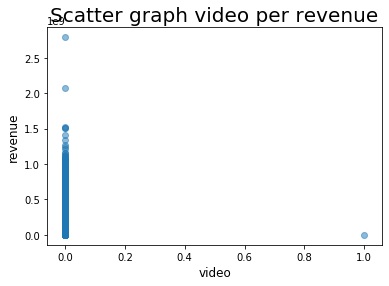

In [69]:
import matplotlib.pyplot as plt
plt.scatter(movies_metadata['video'], movies_metadata['revenue'], alpha = .5)
plt.title('Scatter graph video per revenue', fontsize=20)
plt.xlabel('video', fontsize=12)
plt.ylabel('revenue', fontsize=12)

In [70]:
movies_metadata['original_language'].unique()

array(['en', 'wo', 'it', 'ja', 'cn', 'da', 'zh', 'ko', 'fr', 'ru', 'pt',
       'es', 'th', 'sv', 'no', 'fi', 'hi', 'nl', 'id', 'de', 'ar'],
      dtype=object)

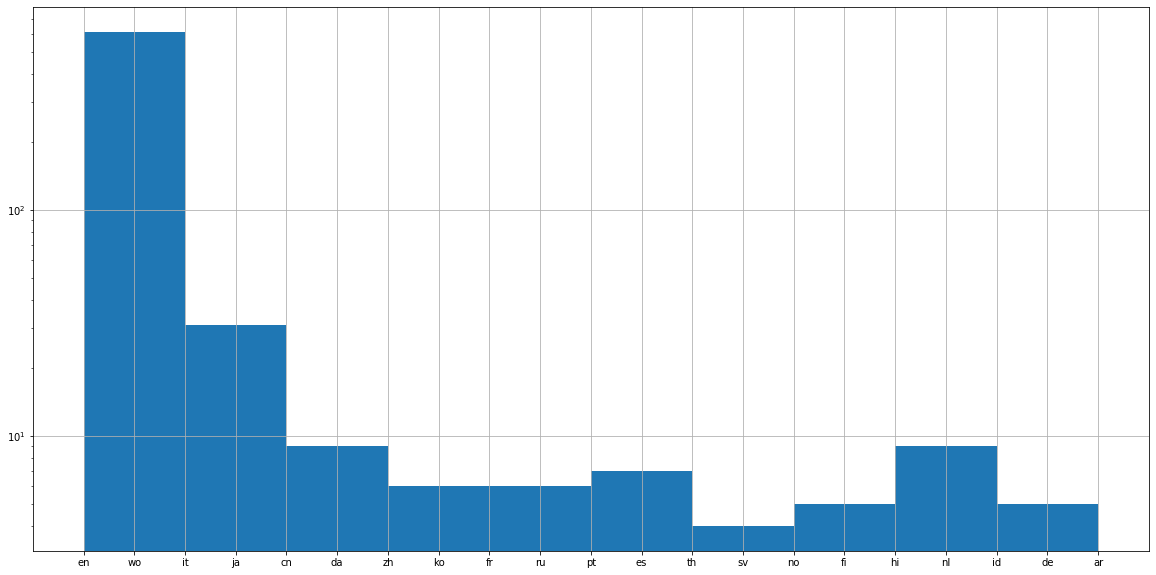

In [71]:
movies_metadata['original_language'].hist(figsize=(20,10), log=True);

In [72]:
movies_metadata = movies_metadata.drop(['adult', 'poster', 'belongs_to_collection', 'imdb_id', 'vote_count', 
                                        'original_language', 'original_title', 'overview', 'tagline', 'video'], axis=1)
movies_metadata.head(2)

,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,number_of_production_companies,number_of_production_countries
9,58000000,Adventure Action Thriller,1,710,14.686,United_Artists Eon_Productions,United_Kingdom United_States_of_America,1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,2,2
68,3500000,Comedy,1,10634,14.5696,New_Line_Cinema,United_States_of_America,1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,1,1


In [73]:
movies_metadata['id'] = movies_metadata['id'].astype(int)

In [74]:
movies_metadata.isnull().sum()

budget                            0
genres                            0
homepage                          0
id                                0
popularity                        0
production_companies              0
production_countries              0
release_date                      0
revenue                           0
runtime                           0
spoken_languages                  0
status                            0
title                             0
vote_average                      0
number_of_popular_genres          0
number_of_production_companies    0
number_of_production_countries    0
dtype: int64

In [75]:
print(movies_metadata.runtime.min())
print(movies_metadata.runtime.max())
print(len(movies_metadata[movies_metadata.runtime < 60]))

0.0
476.0
12


In [76]:
movies_metadata = movies_metadata.drop( movies_metadata[movies_metadata['runtime'] < 60 ].index)
print(movies_metadata.shape)
movies_metadata.head(2)

(681, 17)


,budget,genres,homepage,id,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,number_of_production_companies,number_of_production_countries
9,58000000,Adventure Action Thriller,1,710,14.686,United_Artists Eon_Productions,United_Kingdom United_States_of_America,1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,2,2
68,3500000,Comedy,1,10634,14.5696,New_Line_Cinema,United_States_of_America,1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,1,1


### 지금까지 다듬은 데이터 통합(merge)

In [77]:
merged_df = pd.merge(merged_df, movies_metadata, how='inner', on='id')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,number_of_production_companies,number_of_production_countries
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,710,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,10,113189,58000000,Adventure Action Thriller,1,14.686,United_Artists Eon_Productions,United_Kingdom United_States_of_America,1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,2,2
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,10634,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,69,113118,3500000,Comedy,1,14.5696,New_Line_Cinema,United_States_of_America,1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,1,1
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,755,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,70,116367,19000000,Horror Action Thriller Crime,1,15.3392,A_Band_Apart Dimension_Films Los_Hooligans_Pro...,United_States_of_America,1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4,4,1




---



## ratings : 영화에 대한 평점을 담고있는 dataframe
우리가 예측하고자 하는 데이터입니다.

In [78]:
ratings = ratings.drop_duplicates(ignore_index=True)  # 중복값 없음
print(ratings.shape)

(26124293, 4)


In [79]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [80]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [81]:
ratings = ratings.drop(['userId', 'timestamp'], axis=1)
ratings['rating'].unique()

array([1. , 4.5, 5. , 4. , 3.5, 2.5, 0.5, 3. , 2. , 1.5])

In [82]:
grouped_rating = (ratings.groupby(by="movieId").mean())['rating'].to_frame()
grouped_rating['rating'] = grouped_rating['rating'].round(1)
grouped_rating = grouped_rating.reset_index()

grouped_rating.head(3)

,movieId,rating
0,1,3.9
1,2,3.2
2,3,3.2


In [83]:
grouped_rating.rating.mean(), grouped_rating.rating.median()

(3.0617113223854715, 3.2)

In [84]:
def transform_rating(n) :
  if n >= 3.2 :
    return True
  return False

grouped_rating['rating'] = grouped_rating['rating'].apply(transform_rating)

## 데이터 통합

In [85]:
merged_df = pd.merge(merged_df, grouped_rating, how='inner', on='movieId')
merged_df.head(3)

,crew,id,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,movieId,imdbId,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,number_of_production_companies,number_of_production_countries,rating
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,710,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,10,113189,58000000,Adventure Action Thriller,1,14.686,United_Artists Eon_Productions,United_Kingdom United_States_of_America,1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,2,2,True
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,10634,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,69,113118,3500000,Comedy,1,14.5696,New_Line_Cinema,United_States_of_America,1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,1,1,True
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,755,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,70,116367,19000000,Horror Action Thriller Crime,1,15.3392,A_Band_Apart Dimension_Films Los_Hooligans_Pro...,United_States_of_America,1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4,4,1,True


## 학습하기 좋은 데이터 모양으로 만들기

### train과 test 데이터로 나누기

In [86]:
merged_df.shape, len(merged_df[merged_df['budget']==0])

((681, 26), 0)

In [87]:
final_test = merged_df[merged_df['status'] != 'Released']
train = merged_df[merged_df['status'] == 'Released']
print(train.shape)
print(final_test.shape)

(681, 26)
(0, 26)


In [88]:
print(train['vote_average'].dtype)
len(train[train['vote_average'] == 0])
print(train.shape)
train = train.drop(train[train['vote_average'] == 0].index)
print(train.shape)

float64
(681, 26)
(679, 26)


In [89]:
print(train['rating'].dtype)
len(train[train['rating'] == 0])

bool


303

In [90]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

In [91]:
merged_df = merged_df.drop(['id', 'movieId', 'imdbId'], axis=1)

In [92]:
merged_df.head()

,crew,actors,number_of_named_actors,number_of_named_crews,keywords,number_of_named_keyword,budget,genres,homepage,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,number_of_popular_genres,number_of_production_companies,number_of_production_countries,rating
0,Martin_Campbell Ian_Fleming Jeffrey_Caine Bruc...,Pierce_Brosnan Sean_Bean Izabella_Scorupco Fam...,8,4,cuba falsely_accused secret_identity computer_...,15,58000000,Adventure Action Thriller,1,14.686,United_Artists Eon_Productions,United_Kingdom United_States_of_America,1995-11-16,352194034.0,130.0,3,Released,GoldenEye,6.6,3,2,2,True
1,F_Gary_Gray DJ_Pooh Ice_Cube Frank_Fitzpatrick,Ice_Cube Chris_Tucker Nia_Long Tom_Lister_Jr J...,8,4,rap_music parent_child_relationship rapper job,4,3500000,Comedy,1,14.5696,New_Line_Cinema,United_States_of_America,1995-04-26,28215918.0,91.0,1,Released,Friday,7.0,1,1,1,True
2,Robert_Rodriguez Quentin_Tarantino Quentin_Tar...,George_Clooney Quentin_Tarantino Harvey_Keitel...,8,4,dancing brother_brother_relationship sexual_ob...,26,19000000,Horror Action Thriller Crime,1,15.3392,A_Band_Apart Dimension_Films Los_Hooligans_Pro...,United_States_of_America,1996-01-19,25836616.0,108.0,2,Released,From Dusk Till Dawn,6.9,4,4,1,True
3,Paul_Auster Paul_Auster Wayne_Wang Harvey_Keitel,Harvey_Keitel Lou_Reed Michael_J_Fox Roseanne_...,8,4,smoking corner_shop cigarette tobacco cigar in...,6,2000000,Comedy,1,11.5281,Miramax_Films InterAL,United_States_of_America,1995-09-15,1275000.0,83.0,1,Released,Blue in the Face,6.8,1,2,1,True
4,Suzanne_Todd Graeme_Revell Wayne_Wahrman Josep...,Amy_Jo_Johnson Jason_David_Frank David_Yost Jo...,8,4,based_on_tv_series tokusatsu superhero_team et...,8,15000000,Action Adventure Science_Fiction Family Fantasy,1,7.02423,Twentieth_Century_Fox_Film_Corporation Saban_E...,Japan United_States_of_America,1995-06-30,66000000.0,92.0,1,Released,Mighty Morphin Power Rangers: The Movie,5.2,5,3,2,False


## 상관계수
상관계수를 통해 rating과 다른 데이터 특성관의 관계를 파악

In [93]:
import seaborn as sns
corr = merged_df.corr()
corr['rating']
df_target_corr = corr[['rating']].sort_values('rating', ascending=False)
df_target_corr

,rating
rating,1.000000
vote_average,0.629139
revenue,0.241846
number_of_named_keyword,0.239403
runtime,0.234049
spoken_languages,0.139970
number_of_production_countries,0.080757
number_of_named_crews,0.065205
number_of_popular_genres,0.039117
number_of_named_actors,0.011900


In [94]:
target = 'rating'
features = ['vote_average', 'runtime', 'spoken_languages', 'revenue', 'homepage', 'number_of_named_crews', 'number_of_named_actors']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, X_val.shape, X_test.shape

((434, 7), (109, 7), (136, 7))

### 모델 훈련 1.
#### 랜덤포레스트 모델을 적용하여 분류 예측


In [95]:
# !pip install shap
# !pip install pdp
# !pip install pdpbox
# !pip install category_encoders

In [96]:
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]
basic_model = [major] * len(y_train)
print("기준모델과 훈련용 데이터 학습 정확도 :", accuracy_score(y_train, basic_model))

y_pred_val = [major] * len(y_val)

print("기준모델과 검증용 데이터 학습 정확도 :", accuracy_score(y_val, y_pred_val))

기준모델과 훈련용 데이터 학습 정확도 : 0.5691244239631337
기준모델과 검증용 데이터 학습 정확도 : 0.5045871559633027


In [97]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(max_depth=7, random_state=10, n_jobs=-1, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

from sklearn.metrics import f1_score

y_pred_val = pipe.predict(X_val)
print('검증 f1 score: ', f1_score(y_val, y_pred_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


훈련 정확도:  0.9493087557603687
검증 정확도 0.8623853211009175
검증 f1 score:  0.8623853211009175


In [98]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)

print('검증 정확도: ', accuracy_score(y_val, y_pred_val))
print(classification_report(y_pred_val, y_val))

검증 정확도:  0.8623853211009175
              precision    recall  f1-score   support

       False       0.87      0.85      0.86        55
        True       0.85      0.87      0.86        54

    accuracy                           0.86       109
   macro avg       0.86      0.86      0.86       109
weighted avg       0.86      0.86      0.86       109



In [99]:
pipe.named_steps['randomforestclassifier'].oob_score_

0.8640552995391705

In [100]:
y_pred = pipe.predict(X_train)
print('predict 전 test 정확도: ', pipe.score(X_test, y_test))

from sklearn.metrics import f1_score
print('test f1 score: ', f1_score(y_train, y_pred))

predict 전 test 정확도:  0.8970588235294118
test f1 score:  0.9551020408163265


In [101]:
enc = pipe.named_steps['ordinalencoder']
encoded = enc.transform(X_train)

print('Ordinal  shape: ', encoded.shape)

Ordinal  shape:  (434, 7)


In [102]:
# y_pred = pipe.predict(final_test[features])
# y_pred

In [103]:
print('predict 전 test 정확도: ', pipe.score(X_test, y_test))

predict 전 test 정확도:  0.8970588235294118


## 모델 훈련 결과 시각화

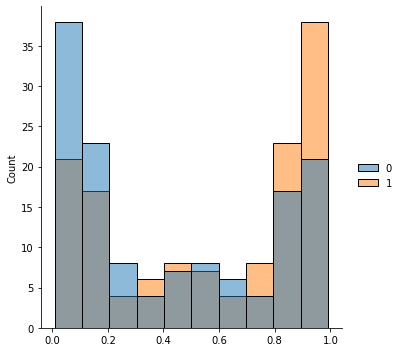

In [104]:
import seaborn as sns
y_pred_proba = pipe.predict_proba(X_test)
# print("Predicted probabilities:\n{}".format(pipe.predict_proba(X_test)))
sns.displot(y_pred_proba);

### Confusion matrix : 분류 모델의 성능 평가 지표를 나타냄 
+ FN : 47, 3.5 **미만**일 때 3.5 **미만**이라고 예측하는 경우
+ TN : 8, 3.5 **이상**일 때 3.5 **미만**이라고 예측하는 경우
+ TP : 47, 3.5 **이상**일 때 3.5 **이상**이라고 예측하는 경우
+ FP : 7, 3.5 **미만**일 때 3.5 **이상**이라고 예측하는 경우

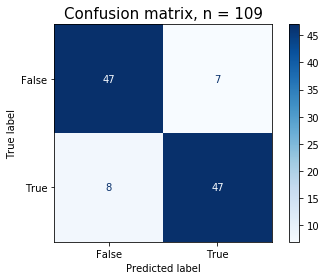

In [105]:
# 분류 모델의 성능 평가 지표를 보여주는 Confusion matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val, cmap=plt.cm.Blues, ax=ax, values_format='')
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

## 임계값에 따른 정밀도, 재현율, f-score의 변화 양상을 볼 수 있는 그래프

In [106]:
# 임계값 (threshold)에 따른 정밀도, 재현율, f-score의 변화를 보기 위해 선언(아래 그래프 참조) 
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

In [107]:
from ipywidgets import interact, fixed
from sklearn.metrics import classification_report

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [108]:
X_train.head()

,vote_average,runtime,spoken_languages,revenue,homepage,number_of_named_crews,number_of_named_actors
133,6.9,85.0,3,0.0,1,4,8
556,7.4,108.0,1,783112979.0,1,4,8
368,6.2,102.0,2,254455986.0,1,4,8
92,6.0,93.0,1,68411275.0,1,4,3
320,7.1,95.0,1,543513985.0,1,4,8


### 모델 훈련 2.
#### XGBClassifier 모델을 적용하여 분류 예측


In [109]:
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('xgb', XGBClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing xgb, total=   0.1s


### 재현율, 정밀도, f1-score 값 확인 가능
+ **정확도** : 전체 범주를 바르게 맞춘 경우
+ **정밀도** : Positive로 예측한 경우 올바르게 Positive로 맞춘 비율
+ **재현율** : 실제 T인 것 중 올바르게 Positive로 맞춘 것의 비율
+ **F1 점수** : 정밀도와 재현율의 조화평균

In [110]:
# 재현율, 정밀도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)

print('검증 정확도: ', accuracy_score(y_val, y_pred))
print(classification_report(y_pred, y_val))

검증 정확도:  0.8623853211009175
              precision    recall  f1-score   support

       False       0.85      0.87      0.86        53
        True       0.87      0.86      0.86        56

    accuracy                           0.86       109
   macro avg       0.86      0.86      0.86       109
weighted avg       0.86      0.86      0.86       109



### 모델 훈련 3.
#### xgboost 모델을 적용하여 분류 예측
1. 회귀와 분류 모두 예측 가능하다.
2. 과적합 방지가 가능하다.


In [111]:
xgb = pipe.named_steps['xgb']
importances = pd.Series(xgb.feature_importances_, X_train.columns)

In [112]:
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

In [113]:
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.8623853211009175
              precision    recall  f1-score   support

       False       0.83      0.88      0.86        51
        True       0.89      0.84      0.87        58

    accuracy                           0.86       109
   macro avg       0.86      0.86      0.86       109
weighted avg       0.86      0.86      0.86       109



In [114]:
import sklearn
import xgboost
import shap
from sklearn.model_selection import train_test_split
import pandas as pd

model = xgboost.XGBRegressor().fit(X_train, y_train)
X_train.head(2)

[07:19:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,vote_average,runtime,spoken_languages,revenue,homepage,number_of_named_crews,number_of_named_actors
133,6.9,85.0,3,0.0,1,4,8
556,7.4,108.0,1,783112979.0,1,4,8


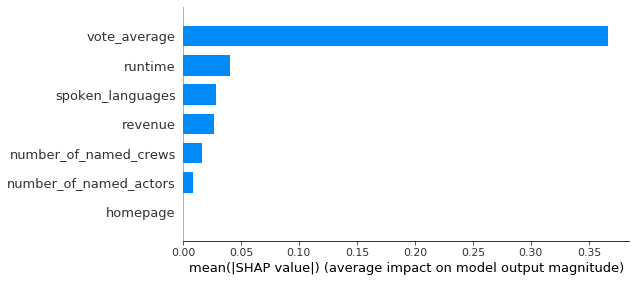

In [115]:
# 특성 중요도 : 데이터가 타겟에 영향력을 미치는 정도를 나타낸다.
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


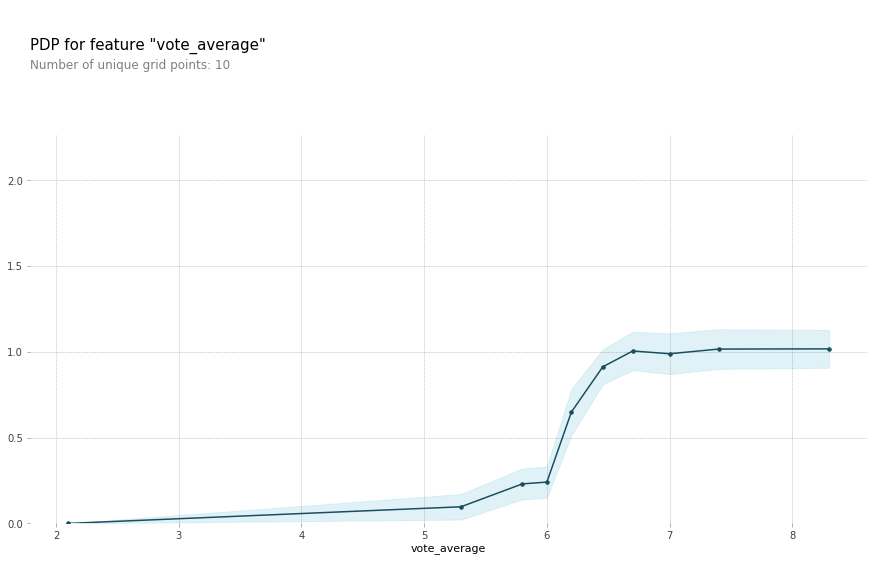

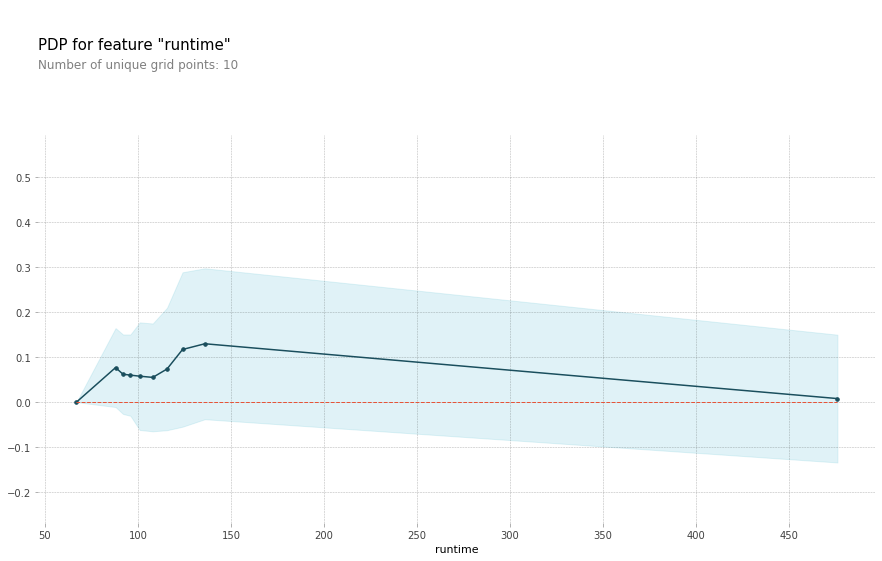

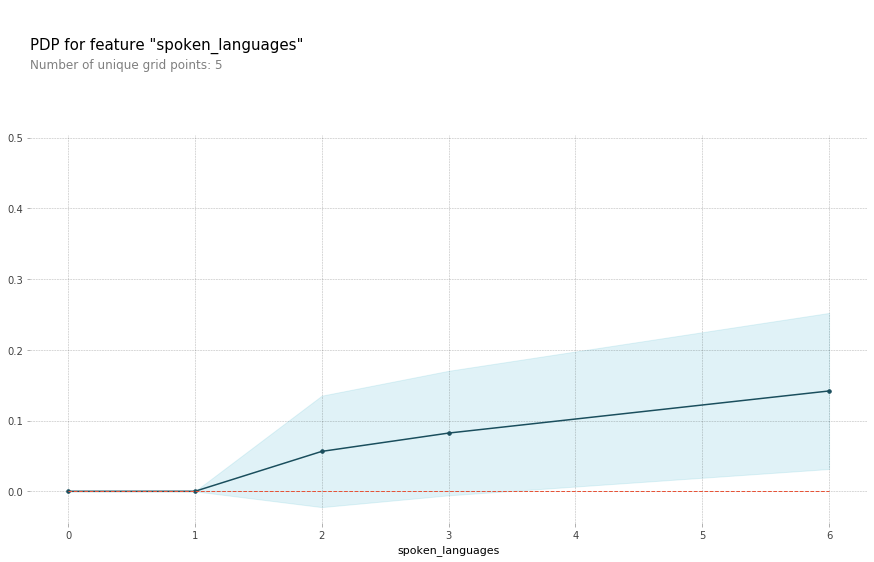

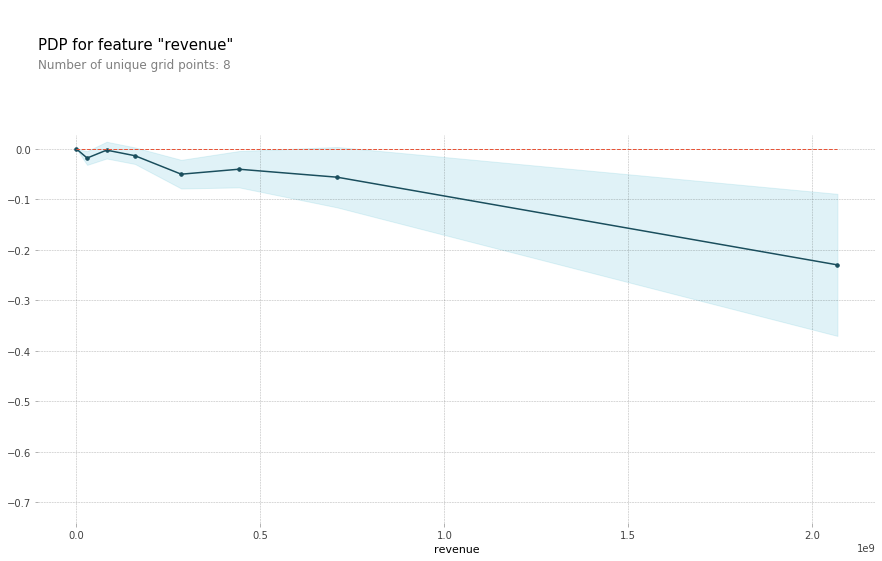

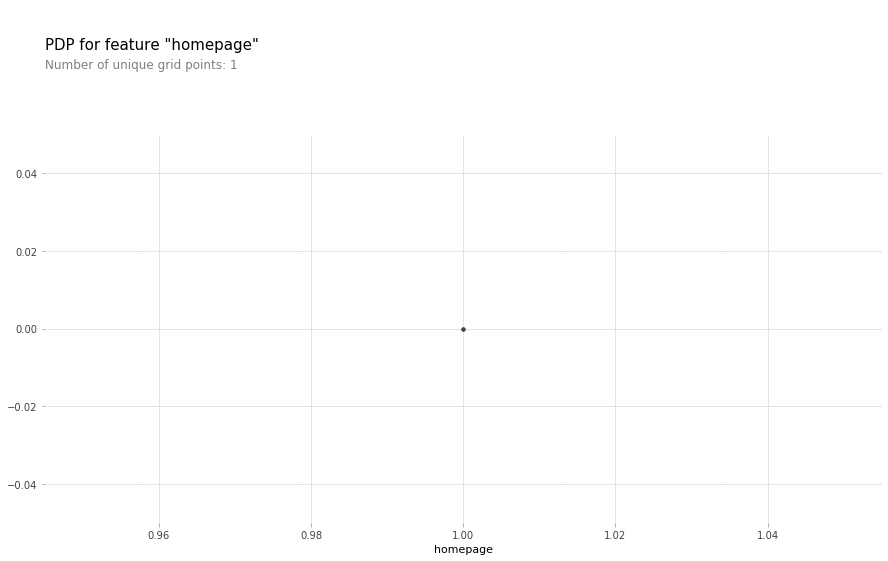

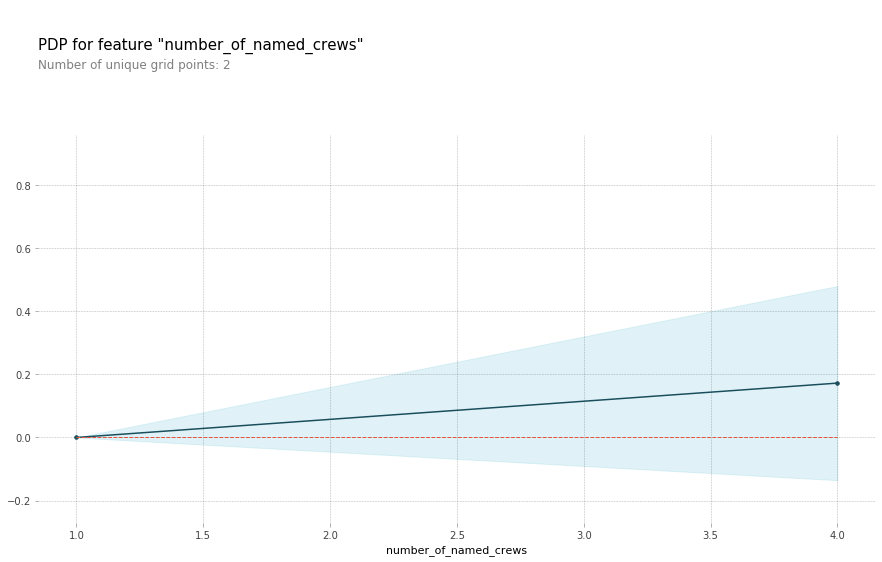

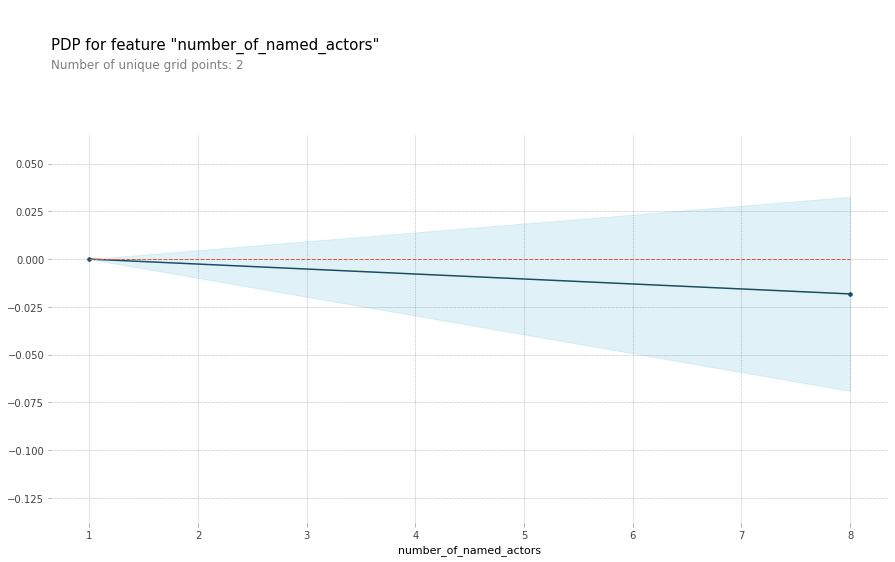

In [116]:
# 부분 의존도 그림 : 특성의 값에 따라서 타겟값에 어떻게 영향을 미쳤는가? 증가/감소/영향x
from pdpbox.pdp import pdp_isolate, pdp_plot

# pdp plot 그리기
for feature in features:
    isolated = pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns,
                           feature=feature, grid_type='percentile', num_grid_points=10)
    pdp_plot(isolated, feature_name=feature)



---

